In [1]:
using Distributions, Plots, StatsPlots, LinearAlgebra, Flux, Zygote, Random

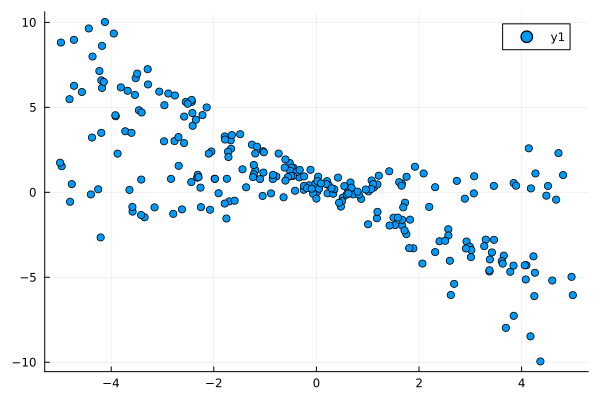

In [2]:
Random.seed!(123)

b0 = 1 .+cumsum(randn(250) .*0.1)
b1 = -1 .+cumsum(randn(250) .*0.1)


X = rand(250) .*10 .-5
y = b0 .+ b1 .* X .+ randn(250).*0.1

scatter(X,y)

In [3]:
struct TimeVaryingRegression
    #Presumes that all coefficients are driven by a random walk
    observation_variance
    
    rw_variances
    
    coeff_means_0
    coeff_vars_0
    
end
Flux.@functor TimeVaryingRegression

TimeVaryingRegression(n_coeffs) = TimeVaryingRegression(ones(1,1), ones(n_coeffs), zeros(n_coeffs), ones(n_coeffs))

TimeVaryingRegression

In [4]:
function kalman_filter(m::TimeVaryingRegression, y, X)
    obsvar = exp(m.observation_variance[1])
    rw_variances = exp.(m.rw_variances)
    
    coeff_means_0 = m.coeff_means_0
    coeff_vars_0 = exp.(m.coeff_vars_0)
    
    return kalman_recursion(y,X,obsvar,rw_variances,coeff_means_0,coeff_vars_0)
end


function kalman_recursion(y, X, obsvar, rw_variances, coeff_means_tm1, coeff_vars_tm1)
     
    coeff_vars_t = coeff_vars_tm1 .+ rw_variances
    coeff_means_t = coeff_means_tm1
    
    y_t = y[1]
    X_t = X[:,1]
    
    y_t_mean = sum(coeff_means_t .* X_t)
    y_t_var = sum(coeff_vars_t .* X_t.^2) + obsvar
    
    coeff_means_t_post = coeff_means_t .+ (coeff_vars_t.*X_t)./y_t_var.*(y_t-y_t_mean)
    coeff_vars_t_post = coeff_vars_t .- (coeff_vars_t.*X_t).^2 ./ y_t_var
    
    dist_t = Normal(y_t_mean, sqrt(y_t_var))
    
    if length(y)>1
        dists_tp1, coeffs_means_tp1, coeffs_vars_tp1 = kalman_recursion(y[2:end],X[:,2:end], 
                                                                  obsvar, rw_variances,
                                                                  coeff_means_t_post,
                                                                  coeff_vars_t_post)
        return vcat(dist_t,dists_tp1), 
               hcat(coeff_means_t_post, coeffs_means_tp1),
               hcat(coeff_vars_t_post, coeffs_vars_tp1)
    else
        return dist_t, coeff_means_t_post, coeff_vars_t_post
    end
end

kalman_recursion (generic function with 1 method)

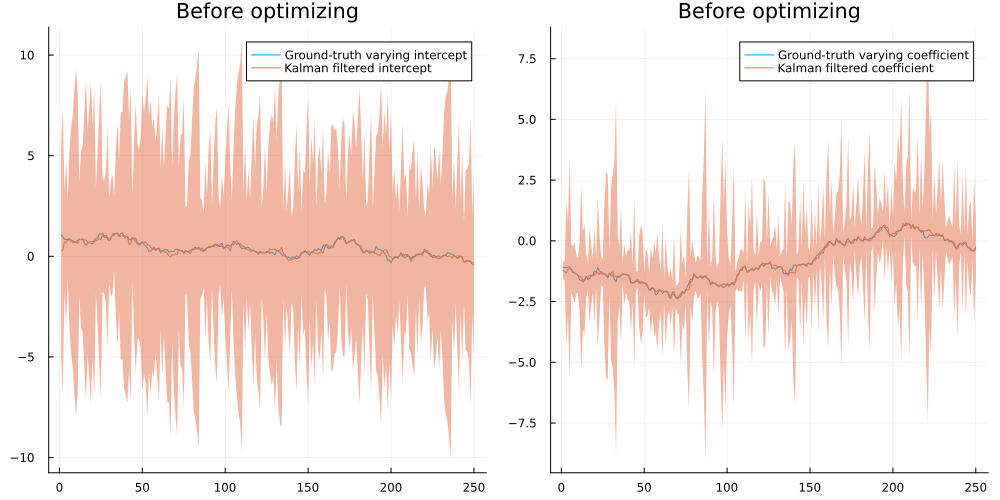

In [5]:
Xc = Matrix(transpose(hcat(ones(length(X)),X)))

model = TimeVaryingRegression(2)

dists_init, coeff_means_init, coeff_vars_init = kalman_filter(model,y,Xc)


p1 = plot(b0, label="Ground-truth varying intercept")
plot!(p1,coeff_means_init[1,:],ribbon= 1 .*coeff_vars_init[1,:],label="Kalman filtered intercept")

p2 = plot(b1, label="Ground-truth varying coefficient")
plot!(p2,coeff_means_init[2,:],ribbon= 1 .*coeff_vars_init[2,:],label="Kalman filtered coefficient")
  
plot(p1,p2,size=(1000,500),fmt=:png,title="Before optimizing")

In [6]:
params = Flux.params(model)
opt = ADAM(0.01)

for i in 1:750
    grads = Zygote.gradient(()->-mean(logpdf.(kalman_filter(model,y,Xc)[1],y)),params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i%75==0
        println(mean(logpdf.(kalman_filter(model,y,Xc)[1],y)))
    end
end

-2.288221451538594
-1.9186016853033478
-1.5566676823511598
-1.2105732966002392
-0.8960431987239883
-0.6384258159294061
-0.46535619001464007
-0.3817636167174806
-0.3554198660243631
-0.349155862641175


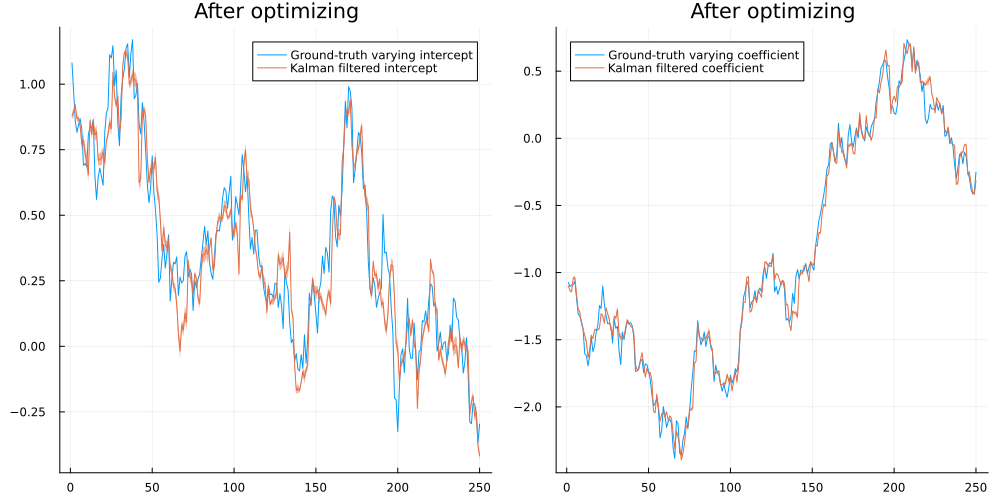

In [7]:
dists_opt, coeff_means_opt, coeff_vars_opt = kalman_filter(model,y,Xc)

p1 = plot(b0, label="Ground-truth varying intercept")
plot!(p1,coeff_means_opt[1,:],ribbon= 1 .*coeff_vars_opt[1,:],label="Kalman filtered intercept")

p2 = plot(b1, label="Ground-truth varying coefficient")
plot!(p2,coeff_means_opt[2,:],ribbon= 1 .*coeff_vars_opt[2,:],label="Kalman filtered coefficient")
  
plot(p1,p2,size=(1000,500),fmt=:png,title="After optimizing")

# Actual dataset
http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In [8]:
using CSV, DataFrames

In [9]:
df = CSV.File("Bike-Sharing-Dataset/day.csv") |> DataFrame


dates = df[!,:dteday]

X_bikes = Float64.(transpose(Matrix(df)[:,3:end-3]))
feature_names = names(df)[3:end-3]
y_bikes = Float64.(Matrix(df)[:,end])

731-element Vector{Float64}:
  985.0
  801.0
 1349.0
 1562.0
 1600.0
 1606.0
 1510.0
  959.0
  822.0
 1321.0
 1263.0
 1162.0
 1406.0
    ⋮
 4128.0
 3623.0
 1749.0
 1787.0
  920.0
 1013.0
  441.0
 2114.0
 3095.0
 1341.0
 1796.0
 2729.0

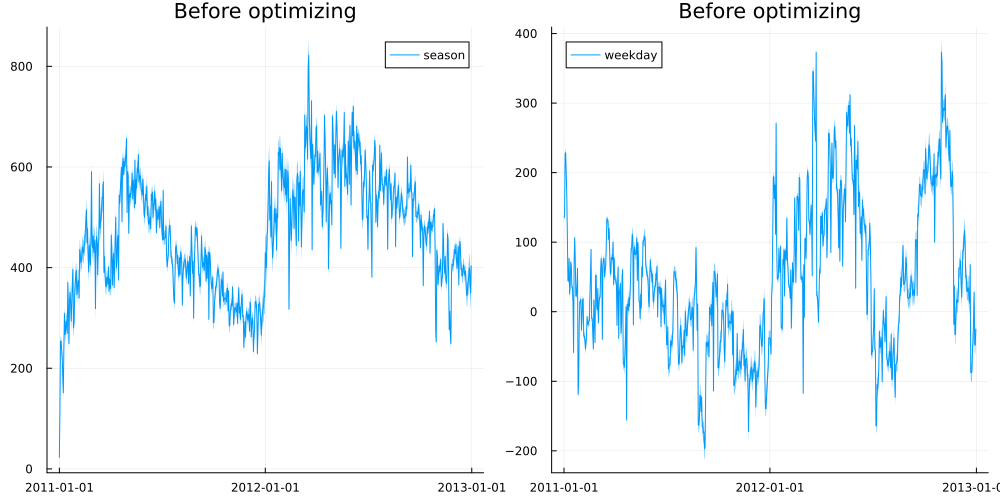

In [10]:
model_bikes = TimeVaryingRegression(size(X_bikes,1))


dists_init, coeff_means_init, coeff_vars_init = kalman_filter(model_bikes,y_bikes,X_bikes)



p1 = plot(dates,coeff_means_init[1,:],ribbon= 1 .*coeff_vars_init[1,:],label=feature_names[1])
p2 = plot(dates,coeff_means_init[5,:],ribbon= 1 .*coeff_vars_init[5,:],label=feature_names[5])
  
plot(p1,p2,size=(1000,500),fmt=:png,title="Before optimizing")

In [11]:
params = Flux.params(model_bikes)
opt = ADAM(0.01)

for i in 1:1000
    grads = Zygote.gradient(()->-mean(logpdf.(kalman_filter(model_bikes,y_bikes,X_bikes)[1],y_bikes)),params)
    Flux.Optimise.update!(opt,params,grads)
    
    if i%100==0
        println(mean(logpdf.(kalman_filter(model_bikes,y_bikes,X_bikes)[1],y_bikes)))
    end
end

-238.7240357728576
-136.91278037253636
-91.21076715361971
-66.48041590921156
-51.461287011112326
-41.59519891957266
-34.73519418523346
-29.75560682594894
-26.016930691810636
-23.132324011570695


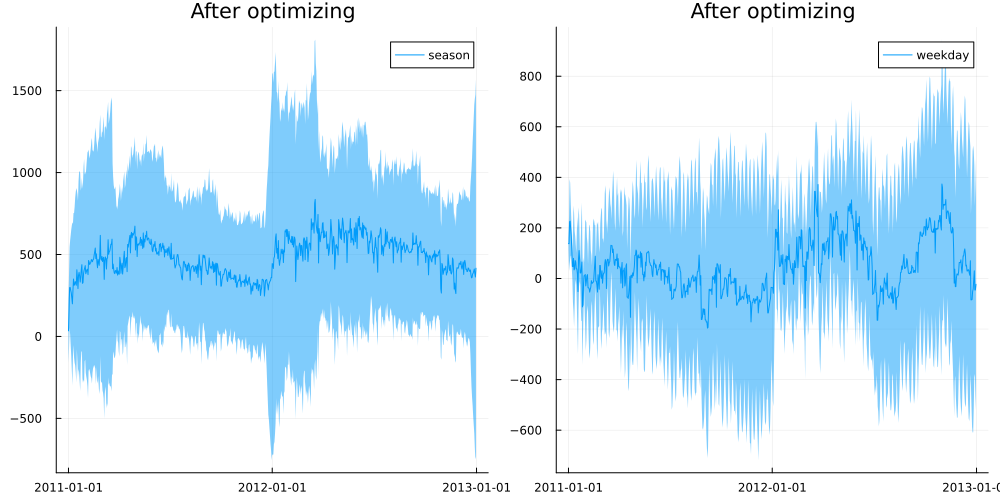

In [12]:
dists_opt, coeff_means_opt, coeff_vars_opt = kalman_filter(model_bikes,y_bikes,X_bikes)

p1 = plot(dates,coeff_means_opt[1,:],ribbon= 1 .*coeff_vars_opt[1,:],label=feature_names[1])
p2 = plot(dates,coeff_means_opt[5,:],ribbon= 1 .*coeff_vars_opt[5,:],label=feature_names[5])
  
plot(p1,p2,size=(1000,500),fmt=:png,title="After optimizing")